In [1]:
# Librerías esenciales
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Configuración del dispositivo: preferencia por MPS (Mac) o CUDA (GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Computando en: {DEVICE}")

Computando en: mps


In [2]:
# Ruta del dataset completo
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"

# Hiperparámetros del modelo
NUM_CLASSES = 2  # binary: 'positive' / 'negative'
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
SCHEDULER_PATIENCE = 5       # ReduceLROnPlateau
EARLYSTOP_PATIENCE = 5       # Early stopping personalizado

# Para guardar el modelo
MODEL_PATH = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV6.pt"

In [3]:
import os
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Eliminar archivos ocultos como .DS_Store que dan errores al iterar
def clean_hidden_files(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.startswith("._") or file == ".DS_Store":
                try:
                    os.remove(os.path.join(root, file))
                except Exception as e:
                    print(f"Error eliminando {file}: {e}")

clean_hidden_files(DATASET_DIR)

# 2️Dataset personalizado para binarizar las etiquetas
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        root = Path(root_dir)
        for part_dir in root.iterdir():
            if part_dir.is_dir():
                for patient_dir in part_dir.iterdir():
                    for study_dir in patient_dir.iterdir():
                        label = 1 if "positive" in study_dir.name.lower() else 0
                        for img_path in study_dir.glob("*.png"):
                            self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformaciones para aumentar robustez del modelo
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset y DataLoaders
train_dataset = MURABinaryDataset(os.path.join(DATASET_DIR, "train"), transform=transform_train)
valid_dataset = MURABinaryDataset(os.path.join(DATASET_DIR, "valid"), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset cargado: {len(train_dataset)} entrenamiento, {len(valid_dataset)} validación")

Dataset cargado: 36808 entrenamiento, 3197 validación


In [4]:
from torchvision import models
import torch.nn as nn

# Cargar modelo preentrenado en ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Congelar todas las capas convolucionales para evitar que se actualicen en el entrenamiento
for param in resnet18.parameters():
    param.requires_grad = False

# Reemplazar la capa final (fc) con una nueva que tenga 2 salidas (binarización)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)

# Enviar modelo al dispositivo de computación adecuado
resnet18 = resnet18.to(DEVICE)

# Ver la arquitectura final
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

✅ Capas convolucionales (conv, bn, relu, maxpool, layer1-layer4):
Ya preentrenadas en ImageNet. Detectan bordes, formas y patrones complejos en imágenes.

🔁 BasicBlock: Cada bloque contiene 2 capas convolucionales y un atajo ("residual connection") para evitar el problema del vanishing gradient (clave en ResNets).

📉 avgpool: Hace una media global espacial → convierte una imagen 2D en un vector.

🎯 fc: La capa final modificada para dar salida a 2 clases (positive, negative).

In [5]:
import torch.optim as optim

# Cálculo del número de ejemplos por clase
train_labels = [label for _, label in train_dataset.samples]
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
weights_tensor = torch.tensor(class_weights).float().to(DEVICE)

# Configuración del entrenamiento
criterion = nn.CrossEntropyLoss(weight=weights_tensor)  # penaliza más a la clase minoritaria
optimizer = optim.Adam(resnet18.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Porque el dataset está algo desbalanceado (negative tiene más ejemplos). Esto compensa el entrenamiento para que no favorezca solo a la clase mayoritaria.

In [6]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Descongelamos solo las capas finales para afinar el modelo preentrenado
for name, param in resnet18.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Historial
history = {
    "train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []
}

# Early stopping
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    resnet18.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    history["train_loss"].append(avg_train_loss)

    # Validación
    resnet18.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    f1 = f1_score(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)

    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(acc)
    history["val_f1"].append(f1)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    # Guardar el mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(resnet18.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV6.pt")
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLYSTOP_PATIENCE:
            print("Early stopping activado.")
            break

Epoch 1 | Train Loss: 0.5539 | Val Loss: 0.5471 | Acc: 0.7451 | F1: 0.6933
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.4938 | Val Loss: 0.5341 | Acc: 0.7632 | F1: 0.7185
Mejor modelo guardado.
Epoch 3 | Train Loss: 0.4730 | Val Loss: 0.4829 | Acc: 0.7735 | F1: 0.7500
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.4514 | Val Loss: 0.4950 | Acc: 0.7795 | F1: 0.7492
Epoch 5 | Train Loss: 0.4319 | Val Loss: 0.4799 | Acc: 0.7698 | F1: 0.7576
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.4112 | Val Loss: 0.5237 | Acc: 0.7832 | F1: 0.7486
Epoch 7 | Train Loss: 0.3950 | Val Loss: 0.4853 | Acc: 0.7823 | F1: 0.7689
Epoch 8 | Train Loss: 0.3767 | Val Loss: 0.5391 | Acc: 0.7814 | F1: 0.7488
Epoch 9 | Train Loss: 0.3253 | Val Loss: 0.5502 | Acc: 0.7757 | F1: 0.7579
Epoch 10 | Train Loss: 0.2983 | Val Loss: 0.5890 | Acc: 0.7779 | F1: 0.7536
Early stopping activado.


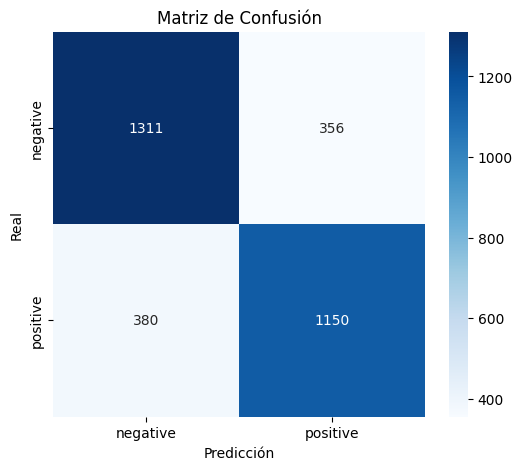

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.79      0.78      1667
    positive       0.76      0.75      0.76      1530

    accuracy                           0.77      3197
   macro avg       0.77      0.77      0.77      3197
weighted avg       0.77      0.77      0.77      3197



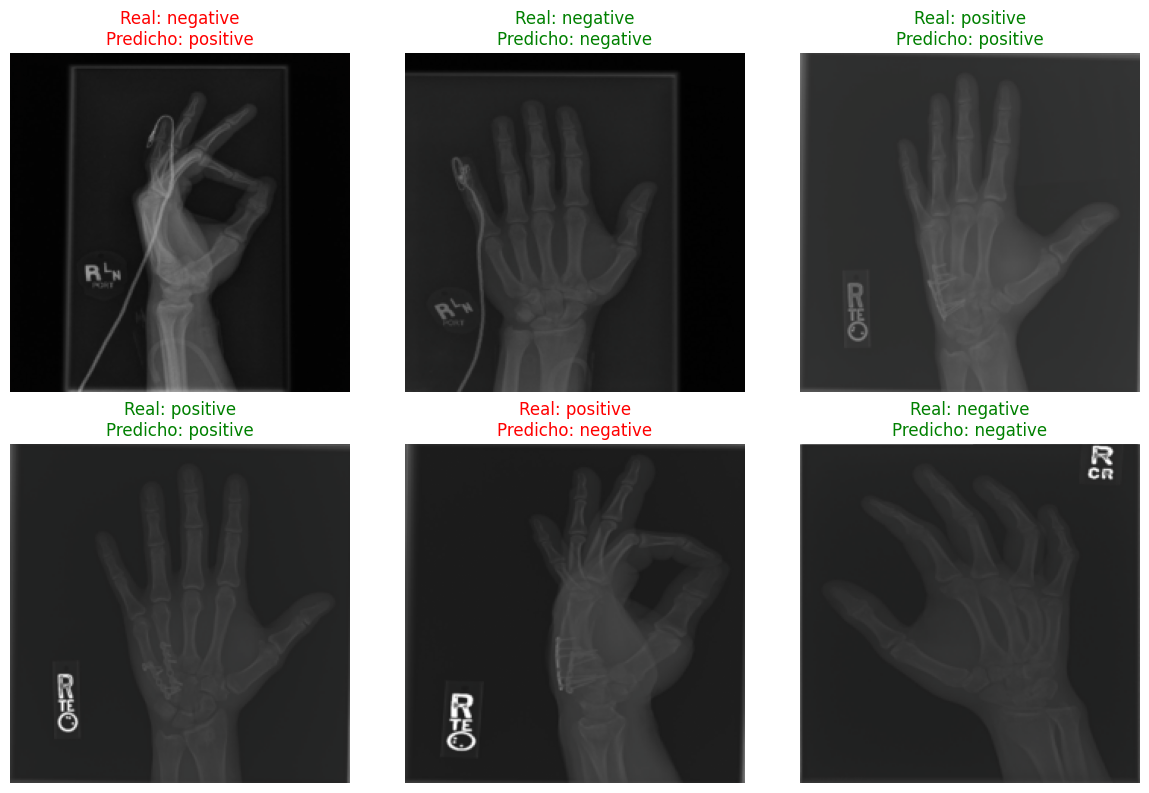

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Asegurarse de que el modelo está en modo evaluación
resnet18.load_state_dict(torch.load("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV6.pt"))
resnet18.eval()

y_true = []
y_pred = []
images_to_show = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Guardar algunas imágenes para mostrar
        if len(images_to_show) < 6:
            for i in range(inputs.size(0)):
                if len(images_to_show) >= 6:
                    break
                images_to_show.append(inputs[i].cpu())
                true_labels.append(labels[i].item())
                pred_labels.append(preds[i].item())

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# Mostrar predicciones
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, img in enumerate(images_to_show):
    img = img.permute(1, 2, 0)  # Reordenar canales para mostrar
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Desnormalizar
    img = img.clamp(0, 1)  # Asegurarse de que esté en rango [0,1]

    axs[i].imshow(img.numpy())
    axs[i].axis('off')
    axs[i].set_title(f"Real: {'positive' if true_labels[i] else 'negative'}\n"
                     f"Predicho: {'positive' if pred_labels[i] else 'negative'}",
                     color='green' if true_labels[i] == pred_labels[i] else 'red')

plt.tight_layout()
plt.show()